<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Solale Mohammadi
### Student Number : 98106015
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [4]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), (0.3081))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [5]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [6]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [28]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), 
        )
        self.seq3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),
            nn.Conv2d(16, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), 
        )
        self.seq5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        res1 = self.seq1(x)
        res2 = self.seq2(res1)
        x = res1+res2
        res3 = self.seq3(x)
        res4 = self.seq4(res3)
        x = res3 + res4
        output = self.seq5(x)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        return output
        

# Train Model (30 Points)

In [40]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [41]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
import copy

total_step = len(train_loader)
num_epochs = 20
train_loss, train_accuracy, validation_loss, validation_accuracy = [], [], [], []

best_result = (0.0,0.0)
best_net = None

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, p = torch.max(outputs, 1)
        correct += (p == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_data)
    avg_accuracy = correct / len(train_data)
    train_loss.append(avg_loss)
    train_accuracy.append(avg_accuracy)
    model.eval()
    
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, p = torch.max(outputs, 1)
            correct_val += (p == labels).sum().item()
            loss_val += loss.item()
        avg_loss_val = loss_val / len(valid_data)
        avg_accuracy_val = correct_val / len(valid_data)
        validation_loss.append(avg_loss_val)
        validation_accuracy.append(avg_accuracy_val)
    if (avg_accuracy_val, avg_loss_val) > best_result:
        best_result = (avg_accuracy_val, avg_loss_val)
        best_net = copy.deepcopy(model)
    model.train()
#     scheduler.step(avg_loss_val)
    print('[epoch %d] Train Loss: %.4f Train Accuracy: %.4f Validation Loss: %.4f Validation Accuracy: %.4f' % (
        epoch + 1, avg_loss, avg_accuracy, avg_loss_val, avg_accuracy_val))

[epoch 1] Train Loss: 0.0132 Train Accuracy: 0.3797 Validation Loss: 0.0071 Validation Accuracy: 0.8567
[epoch 2] Train Loss: 0.0022 Train Accuracy: 0.9105 Validation Loss: 0.0033 Validation Accuracy: 0.9380
[epoch 3] Train Loss: 0.0011 Train Accuracy: 0.9555 Validation Loss: 0.0019 Validation Accuracy: 0.9644
[epoch 4] Train Loss: 0.0008 Train Accuracy: 0.9671 Validation Loss: 0.0013 Validation Accuracy: 0.9758
[epoch 5] Train Loss: 0.0006 Train Accuracy: 0.9747 Validation Loss: 0.0011 Validation Accuracy: 0.9793
[epoch 6] Train Loss: 0.0005 Train Accuracy: 0.9784 Validation Loss: 0.0009 Validation Accuracy: 0.9821
[epoch 7] Train Loss: 0.0005 Train Accuracy: 0.9808 Validation Loss: 0.0008 Validation Accuracy: 0.9837
[epoch 8] Train Loss: 0.0004 Train Accuracy: 0.9832 Validation Loss: 0.0009 Validation Accuracy: 0.9834
[epoch 9] Train Loss: 0.0004 Train Accuracy: 0.9847 Validation Loss: 0.0008 Validation Accuracy: 0.9851
[epoch 10] Train Loss: 0.0004 Train Accuracy: 0.9857 Validation 

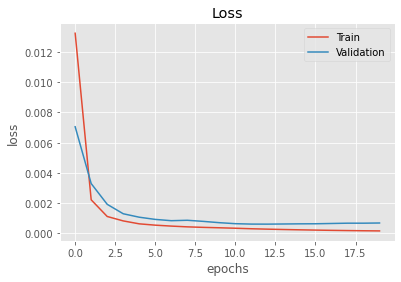

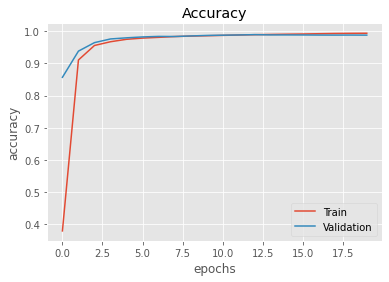

In [42]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('Loss')
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Test Model (20 Points)

In [44]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

accurate = 0.0
running_loss = 0.0
best_net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_net(images)
        running_loss += criterion(outputs, labels).item()
        _, p = torch.max(outputs, 1)
        accurate += (p == labels).squeeze().sum().item()
accuracy= accurate / len(test_loader.dataset)
loss =  running_loss / len(test_loader.dataset)
print(f'final accuracy: {accuracy}, finalloss: {loss}')

10000
final accuracy: 0.989, finalloss: 0.0005108153498960746
